In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm import tqdm
import torch.nn.functional as F

# from dataset import LensDataset

In [3]:
# import torch.multiprocessing as mp

# mp.set_start_method("spawn", force=True)

In [4]:
!pip install wandb
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: samkitshah1262 (samkitshah1262-warner-bros-discovery) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(project="grayscale-image-classification", entity="samkitshah1262-warner-bros-discovery")

In [6]:
# import gdown

# url = "https://drive.google.com/uc?id=12p4fMT2HmiDtu-PL_VNiByXxZnaBle84"
# output = "dataset.zip"
# gdown.download(url, output)
# !unzip -q dataset.zip

In [7]:
set_images_no = []
for i in range(10):
    set_images_no.append(np.load(f"dataset/train/no/{i+1}.npy"))
set_images_sphere = []
for i in range(10):
    set_images_sphere.append(np.load(f"dataset/train/sphere/{i+1}.npy"))
set_images_vortex = []
for i in range(10):
    set_images_vortex.append(np.load(f"dataset/train/vort/{i+1}.npy"))

In [8]:
img = np.load("dataset/train/no/1.npy")
img = torch.tensor(img, dtype=torch.float32)
img.shape

torch.Size([1, 150, 150])

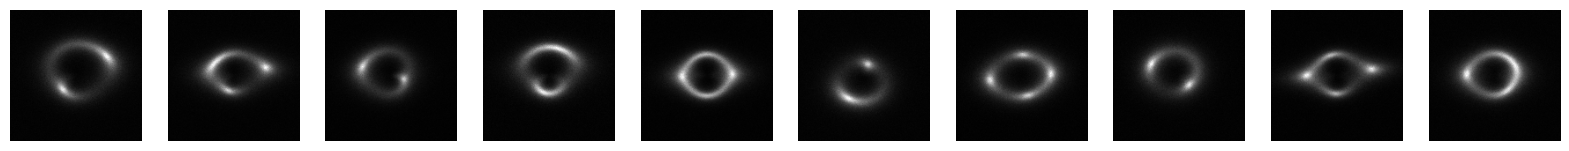

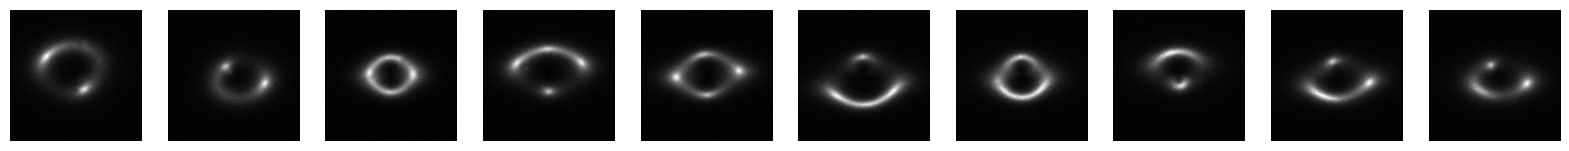

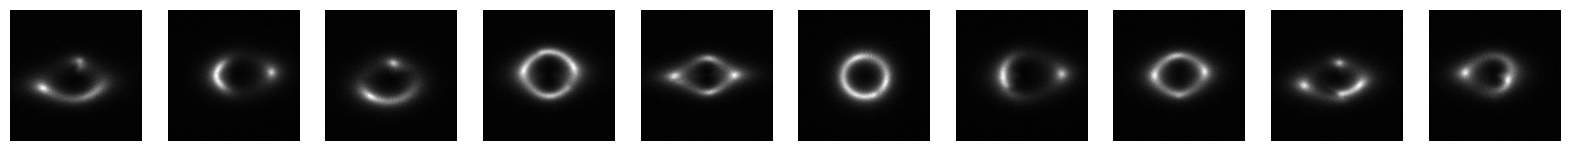

In [9]:
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(set_images_no[i][0], cmap='gray')
    axs[i].axis('off')
plt.show()

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(set_images_sphere[i][0], cmap='gray')
    axs[i].axis('off')
plt.show()

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(set_images_vortex[i][0], cmap='gray')
    axs[i].axis('off')

plt.show()

In [10]:
def load_data(data_dir):
    """ Loads .npy files and assigns labels based on folder names. """
    file_paths, labels = [], []

    class_names = ["no", "sphere", "vort"]
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith('.npy'):
                file_paths.append(os.path.join(class_dir, file))
                labels.append(label_map[class_name])

    return file_paths, labels, label_map


In [11]:
def repeat_channels(x):
    if x.ndimension() == 2:
        x = x.unsqueeze(0)
    return x.repeat(3, 1, 1) 

transform = transforms.Compose([
    transforms.Lambda(repeat_channels),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset


class LensDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = np.load(self.file_paths[idx])  # Load .npy file
        img = torch.tensor(img, dtype=torch.float32)  # Convert to tensor
        # img = img.unsqueeze(1)  # Add channel dimension (1, H, W)

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label


In [13]:
train_files, train_labels, label_map = load_data('dataset/train')
val_files, val_labels, _ = load_data('dataset/val')

# Create Datasets
train_dataset = LensDataset(train_files, train_labels, transform)
val_dataset = LensDataset(val_files, val_labels, transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


In [14]:
print(train_dataset[0][0].shape)

torch.Size([3, 150, 150])


In [15]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=3)
model = torch.compile(model)
model.conv_stem = nn.Conv2d(3, 40, kernel_size=3, stride=2, padding=1, bias=False)
model = model.to(device)


In [16]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10)


In [26]:
import time

def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    total_batches = len(train_loader)

    start_time = time.time()

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        all_preds.append(outputs.detach().cpu())
        all_labels.append(labels.detach().cpu())

        if batch_idx % 10 == 0 or batch_idx == total_batches - 1:
            print(f"Batch [{batch_idx+1}/{total_batches}] - Loss: {loss.item():.4f}")

    epoch_time = time.time() - start_time
    print(f"⏳ Epoch took {epoch_time:.2f} seconds")

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    all_preds_probs = F.softmax(all_preds, dim=1)
    auc = roc_auc_score(all_labels.numpy(), all_preds_probs.numpy(), multi_class='ovr')
    return running_loss / total_batches, auc

In [27]:
def validate_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    total_batches = len(val_loader)

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

            if batch_idx % 10 == 0 or batch_idx == total_batches - 1:
                print(f"Validation Batch [{batch_idx+1}/{total_batches}] - Loss: {loss.item():.4f}")

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    all_preds_probs = F.softmax(all_preds, dim=1)
    auc = roc_auc_score(all_labels.numpy(), all_preds_probs.numpy(), multi_class='ovr')
    return running_loss / total_batches, auc

In [28]:
num_epochs = 50
best_auc = 0.0


for epoch in tqdm(range(num_epochs)):

    train_loss, train_auc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_auc = validate_epoch(model, val_loader, criterion)

    log_message = f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train AUC={train_auc:.4f} | Val Loss={val_loss:.4f}, Val AUC={val_auc:.4f}"

    print(log_message)

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss/len(train_loader),
        "train_auc": train_auc,
        "val_loss": val_loss,
        "val_auc": val_auc
    })
    scheduler.step()

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "EN3B.pth")
        print("Best model saved!")


  0%|          | 0/50 [00:00<?, ?it/s]

Batch [1/1875] - Loss: 1.7828
Batch [11/1875] - Loss: 1.0996
Batch [21/1875] - Loss: 1.5543
Batch [31/1875] - Loss: 1.2207
Batch [41/1875] - Loss: 1.4957
Batch [51/1875] - Loss: 1.1089
Batch [61/1875] - Loss: 1.4480
Batch [71/1875] - Loss: 1.1120
Batch [81/1875] - Loss: 1.0945
Batch [91/1875] - Loss: 1.3950
Batch [101/1875] - Loss: 1.1172
Batch [111/1875] - Loss: 1.5818
Batch [121/1875] - Loss: 1.1940
Batch [131/1875] - Loss: 1.3126
Batch [141/1875] - Loss: 1.3452
Batch [151/1875] - Loss: 1.2932
Batch [161/1875] - Loss: 1.4495
Batch [171/1875] - Loss: 1.2104
Batch [181/1875] - Loss: 1.1231
Batch [191/1875] - Loss: 1.0883
Batch [201/1875] - Loss: 1.1228
Batch [211/1875] - Loss: 1.4190
Batch [221/1875] - Loss: 1.1957
Batch [231/1875] - Loss: 1.4670
Batch [241/1875] - Loss: 1.0933
Batch [251/1875] - Loss: 1.0188
Batch [261/1875] - Loss: 1.3302
Batch [271/1875] - Loss: 1.1357
Batch [281/1875] - Loss: 1.1395
Batch [291/1875] - Loss: 1.0474
Batch [301/1875] - Loss: 0.8556
Batch [311/1875] - 

  2%|▏         | 1/50 [06:58<5:41:40, 418.38s/it]

Validation Batch [469/469] - Loss: 1.1728
Epoch 1: Train Loss=1.1542, Train AUC=0.5202 | Val Loss=1.1477, Val AUC=0.5381
✅ Best model saved!
Batch [1/1875] - Loss: 1.0739
Batch [11/1875] - Loss: 1.0986
Batch [21/1875] - Loss: 1.1437
Batch [31/1875] - Loss: 1.0611
Batch [41/1875] - Loss: 1.1492
Batch [51/1875] - Loss: 1.1073
Batch [61/1875] - Loss: 1.1103
Batch [71/1875] - Loss: 1.1392
Batch [81/1875] - Loss: 1.0697
Batch [91/1875] - Loss: 1.0444
Batch [101/1875] - Loss: 1.1097
Batch [111/1875] - Loss: 1.0759
Batch [121/1875] - Loss: 1.0850
Batch [131/1875] - Loss: 1.0544
Batch [141/1875] - Loss: 1.1459
Batch [151/1875] - Loss: 1.2639
Batch [161/1875] - Loss: 1.0912
Batch [171/1875] - Loss: 1.0909
Batch [181/1875] - Loss: 1.1562
Batch [191/1875] - Loss: 1.2593
Batch [201/1875] - Loss: 1.0664
Batch [211/1875] - Loss: 1.2063
Batch [221/1875] - Loss: 1.0783
Batch [231/1875] - Loss: 1.0791
Batch [241/1875] - Loss: 1.1326
Batch [251/1875] - Loss: 0.9924
Batch [261/1875] - Loss: 1.1262
Batch 

  4%|▍         | 2/50 [13:46<5:29:55, 412.40s/it]

Validation Batch [469/469] - Loss: 1.1163
Epoch 2: Train Loss=1.0918, Train AUC=0.5578 | Val Loss=1.0586, Val AUC=0.6153
✅ Best model saved!
Batch [1/1875] - Loss: 1.0051
Batch [11/1875] - Loss: 1.1752
Batch [21/1875] - Loss: 1.2091
Batch [31/1875] - Loss: 0.9476
Batch [41/1875] - Loss: 1.0251
Batch [51/1875] - Loss: 1.1376
Batch [61/1875] - Loss: 1.0550
Batch [71/1875] - Loss: 1.0018
Batch [81/1875] - Loss: 1.0083
Batch [91/1875] - Loss: 1.0399
Batch [101/1875] - Loss: 0.9721
Batch [111/1875] - Loss: 1.0924
Batch [121/1875] - Loss: 0.9706
Batch [131/1875] - Loss: 1.1242
Batch [141/1875] - Loss: 1.1542
Batch [151/1875] - Loss: 1.1026
Batch [161/1875] - Loss: 1.0495
Batch [171/1875] - Loss: 1.0722
Batch [181/1875] - Loss: 1.0030
Batch [191/1875] - Loss: 0.9880
Batch [201/1875] - Loss: 1.1077
Batch [211/1875] - Loss: 1.1999
Batch [221/1875] - Loss: 1.0568
Batch [231/1875] - Loss: 1.0129
Batch [241/1875] - Loss: 1.0944
Batch [251/1875] - Loss: 1.0232
Batch [261/1875] - Loss: 0.9360
Batch 

  6%|▌         | 3/50 [20:32<5:20:53, 409.64s/it]

Validation Batch [469/469] - Loss: 0.8282
Epoch 3: Train Loss=0.9553, Train AUC=0.7080 | Val Loss=0.7558, Val AUC=0.8318
✅ Best model saved!
Batch [1/1875] - Loss: 0.8948
Batch [11/1875] - Loss: 1.0032
Batch [21/1875] - Loss: 0.6491
Batch [31/1875] - Loss: 0.7677
Batch [41/1875] - Loss: 0.8952
Batch [51/1875] - Loss: 0.4670
Batch [61/1875] - Loss: 0.7712
Batch [71/1875] - Loss: 0.5952
Batch [81/1875] - Loss: 1.0675
Batch [91/1875] - Loss: 0.7722
Batch [101/1875] - Loss: 0.6738
Batch [111/1875] - Loss: 0.7552
Batch [121/1875] - Loss: 0.7349
Batch [131/1875] - Loss: 0.6108
Batch [141/1875] - Loss: 0.6065
Batch [151/1875] - Loss: 0.7194
Batch [161/1875] - Loss: 0.7418
Batch [171/1875] - Loss: 0.6649
Batch [181/1875] - Loss: 0.5086
Batch [191/1875] - Loss: 0.7267
Batch [201/1875] - Loss: 0.7466
Batch [211/1875] - Loss: 0.7108
Batch [221/1875] - Loss: 0.5850
Batch [231/1875] - Loss: 0.8023
Batch [241/1875] - Loss: 0.7907
Batch [251/1875] - Loss: 0.6773
Batch [261/1875] - Loss: 0.8326
Batch 

  8%|▊         | 4/50 [27:46<5:21:23, 419.22s/it]

Validation Batch [469/469] - Loss: 0.4253
Epoch 4: Train Loss=0.6674, Train AUC=0.8698 | Val Loss=0.5747, Val AUC=0.9083
✅ Best model saved!
Batch [1/1875] - Loss: 0.6768
Batch [11/1875] - Loss: 0.6571
Batch [21/1875] - Loss: 0.6307
Batch [31/1875] - Loss: 1.1340
Batch [41/1875] - Loss: 0.5340
Batch [51/1875] - Loss: 0.6046
Batch [61/1875] - Loss: 0.6205
Batch [71/1875] - Loss: 0.6363
Batch [81/1875] - Loss: 0.4236
Batch [91/1875] - Loss: 0.5681
Batch [101/1875] - Loss: 0.4040
Batch [111/1875] - Loss: 0.3995
Batch [121/1875] - Loss: 0.5863
Batch [131/1875] - Loss: 0.6638
Batch [141/1875] - Loss: 0.6127
Batch [151/1875] - Loss: 0.4847
Batch [161/1875] - Loss: 0.7433
Batch [171/1875] - Loss: 0.2375
Batch [181/1875] - Loss: 0.3396
Batch [191/1875] - Loss: 0.5253
Batch [201/1875] - Loss: 0.5697
Batch [211/1875] - Loss: 0.3708
Batch [221/1875] - Loss: 0.5217
Batch [231/1875] - Loss: 0.7156
Batch [241/1875] - Loss: 0.6592
Batch [251/1875] - Loss: 0.6215
Batch [261/1875] - Loss: 1.1260
Batch 

 10%|█         | 5/50 [34:52<5:16:08, 421.53s/it]

Validation Batch [469/469] - Loss: 0.3927
Epoch 5: Train Loss=0.5178, Train AUC=0.9217 | Val Loss=0.4480, Val AUC=0.9411
✅ Best model saved!
Batch [1/1875] - Loss: 1.0965
Batch [11/1875] - Loss: 0.5024
Batch [21/1875] - Loss: 0.3451
Batch [31/1875] - Loss: 0.1581
Batch [41/1875] - Loss: 0.3298
Batch [51/1875] - Loss: 0.6365
Batch [61/1875] - Loss: 0.5028
Batch [71/1875] - Loss: 0.4404
Batch [81/1875] - Loss: 0.5550
Batch [91/1875] - Loss: 0.4775
Batch [101/1875] - Loss: 0.3712
Batch [111/1875] - Loss: 0.3031
Batch [121/1875] - Loss: 0.7040
Batch [131/1875] - Loss: 0.3056
Batch [141/1875] - Loss: 0.5513
Batch [151/1875] - Loss: 0.8221
Batch [161/1875] - Loss: 0.8859
Batch [171/1875] - Loss: 0.3827
Batch [181/1875] - Loss: 0.3792
Batch [191/1875] - Loss: 0.3846
Batch [201/1875] - Loss: 0.5362
Batch [211/1875] - Loss: 0.4630
Batch [221/1875] - Loss: 0.4645
Batch [231/1875] - Loss: 0.4071
Batch [241/1875] - Loss: 0.7525
Batch [251/1875] - Loss: 0.5338
Batch [261/1875] - Loss: 0.3016
Batch 

 12%|█▏        | 6/50 [41:40<5:05:44, 416.92s/it]

Validation Batch [469/469] - Loss: 0.6123
Epoch 6: Train Loss=0.4355, Train AUC=0.9439 | Val Loss=0.3944, Val AUC=0.9558
✅ Best model saved!
Batch [1/1875] - Loss: 0.3170
Batch [11/1875] - Loss: 0.3767
Batch [21/1875] - Loss: 0.2898
Batch [31/1875] - Loss: 0.4594
Batch [41/1875] - Loss: 0.1237
Batch [51/1875] - Loss: 0.1462
Batch [61/1875] - Loss: 0.5146
Batch [71/1875] - Loss: 0.4384
Batch [81/1875] - Loss: 0.4483
Batch [91/1875] - Loss: 0.2910
Batch [101/1875] - Loss: 0.5118
Batch [111/1875] - Loss: 0.5439
Batch [121/1875] - Loss: 0.2096
Batch [131/1875] - Loss: 0.3861
Batch [141/1875] - Loss: 0.3641
Batch [151/1875] - Loss: 0.2609
Batch [161/1875] - Loss: 0.4702
Batch [171/1875] - Loss: 0.1165
Batch [181/1875] - Loss: 0.1123
Batch [191/1875] - Loss: 0.3587
Batch [201/1875] - Loss: 0.5307
Batch [211/1875] - Loss: 0.1788
Batch [221/1875] - Loss: 0.4164
Batch [231/1875] - Loss: 0.1781
Batch [241/1875] - Loss: 0.4541
Batch [251/1875] - Loss: 0.3828
Batch [261/1875] - Loss: 0.2185
Batch 

 14%|█▍        | 7/50 [48:20<4:54:45, 411.28s/it]

Validation Batch [469/469] - Loss: 0.3251
Epoch 7: Train Loss=0.3733, Train AUC=0.9583 | Val Loss=0.3648, Val AUC=0.9601
✅ Best model saved!
Batch [1/1875] - Loss: 0.7222
Batch [11/1875] - Loss: 0.2830
Batch [21/1875] - Loss: 0.5861
Batch [31/1875] - Loss: 0.5446
Batch [41/1875] - Loss: 0.6213
Batch [51/1875] - Loss: 0.3615
Batch [61/1875] - Loss: 0.3986
Batch [71/1875] - Loss: 0.1247
Batch [81/1875] - Loss: 0.2522
Batch [91/1875] - Loss: 0.4403
Batch [101/1875] - Loss: 0.3783
Batch [111/1875] - Loss: 0.6157
Batch [121/1875] - Loss: 0.2371
Batch [131/1875] - Loss: 0.6282
Batch [141/1875] - Loss: 0.2932
Batch [151/1875] - Loss: 0.2230
Batch [161/1875] - Loss: 0.2765
Batch [171/1875] - Loss: 0.1673
Batch [181/1875] - Loss: 0.3690
Batch [191/1875] - Loss: 0.3520
Batch [201/1875] - Loss: 0.2421
Batch [211/1875] - Loss: 0.4129
Batch [221/1875] - Loss: 0.3895
Batch [231/1875] - Loss: 0.3030
Batch [241/1875] - Loss: 0.1391
Batch [251/1875] - Loss: 0.5520
Batch [261/1875] - Loss: 0.2027
Batch 

 16%|█▌        | 8/50 [55:00<4:45:22, 407.68s/it]

Validation Batch [469/469] - Loss: 0.5432
Epoch 8: Train Loss=0.3484, Train AUC=0.9636 | Val Loss=0.3319, Val AUC=0.9672
✅ Best model saved!
Batch [1/1875] - Loss: 0.2199
Batch [11/1875] - Loss: 0.5512
Batch [21/1875] - Loss: 0.2210
Batch [31/1875] - Loss: 0.2648
Batch [41/1875] - Loss: 0.5168
Batch [51/1875] - Loss: 0.8014
Batch [61/1875] - Loss: 0.1860
Batch [71/1875] - Loss: 0.3130
Batch [81/1875] - Loss: 0.4717
Batch [91/1875] - Loss: 0.1502
Batch [101/1875] - Loss: 0.1667
Batch [111/1875] - Loss: 0.2756
Batch [121/1875] - Loss: 0.1352
Batch [131/1875] - Loss: 0.4153
Batch [141/1875] - Loss: 0.2369
Batch [151/1875] - Loss: 0.4674
Batch [161/1875] - Loss: 0.7208
Batch [171/1875] - Loss: 0.5424
Batch [181/1875] - Loss: 0.2921
Batch [191/1875] - Loss: 0.1324
Batch [201/1875] - Loss: 0.1967
Batch [211/1875] - Loss: 0.1074
Batch [221/1875] - Loss: 0.4412
Batch [231/1875] - Loss: 0.5068
Batch [241/1875] - Loss: 0.4341
Batch [251/1875] - Loss: 0.5028
Batch [261/1875] - Loss: 0.4932
Batch 

 18%|█▊        | 9/50 [1:01:43<4:37:44, 406.46s/it]

Validation Batch [469/469] - Loss: 0.4063
Epoch 9: Train Loss=0.3266, Train AUC=0.9675 | Val Loss=0.3225, Val AUC=0.9680
✅ Best model saved!
Batch [1/1875] - Loss: 0.1612
Batch [11/1875] - Loss: 0.2556
Batch [21/1875] - Loss: 0.1178
Batch [31/1875] - Loss: 0.3696
Batch [41/1875] - Loss: 0.3172
Batch [51/1875] - Loss: 0.4402
Batch [61/1875] - Loss: 0.1966
Batch [71/1875] - Loss: 0.1117
Batch [81/1875] - Loss: 0.5490
Batch [91/1875] - Loss: 0.3117
Batch [101/1875] - Loss: 0.7694
Batch [111/1875] - Loss: 0.3654
Batch [121/1875] - Loss: 0.2358
Batch [131/1875] - Loss: 0.2493
Batch [141/1875] - Loss: 0.0957
Batch [151/1875] - Loss: 0.2856
Batch [161/1875] - Loss: 0.1744
Batch [171/1875] - Loss: 0.4376
Batch [181/1875] - Loss: 0.2380
Batch [191/1875] - Loss: 0.3853
Batch [201/1875] - Loss: 0.0702
Batch [211/1875] - Loss: 0.4428
Batch [221/1875] - Loss: 0.2028
Batch [231/1875] - Loss: 0.1530
Batch [241/1875] - Loss: 0.3711
Batch [251/1875] - Loss: 0.4385
Batch [261/1875] - Loss: 0.2341
Batch 

 20%|██        | 10/50 [1:08:23<4:29:33, 404.33s/it]

Validation Batch [469/469] - Loss: 0.6804
Epoch 10: Train Loss=0.3139, Train AUC=0.9699 | Val Loss=0.3273, Val AUC=0.9670
Batch [1/1875] - Loss: 0.2436
Batch [11/1875] - Loss: 0.4467
Batch [21/1875] - Loss: 0.3765
Batch [31/1875] - Loss: 0.3233
Batch [41/1875] - Loss: 0.0964
Batch [51/1875] - Loss: 0.3065
Batch [61/1875] - Loss: 0.3241
Batch [71/1875] - Loss: 0.2074
Batch [81/1875] - Loss: 0.3669
Batch [91/1875] - Loss: 0.1428
Batch [101/1875] - Loss: 0.2094
Batch [111/1875] - Loss: 0.2334
Batch [121/1875] - Loss: 0.3762
Batch [131/1875] - Loss: 0.6331
Batch [141/1875] - Loss: 0.5266
Batch [151/1875] - Loss: 0.2484
Batch [161/1875] - Loss: 0.2184
Batch [171/1875] - Loss: 0.2684
Batch [181/1875] - Loss: 0.1280
Batch [191/1875] - Loss: 0.2662
Batch [201/1875] - Loss: 0.1175
Batch [211/1875] - Loss: 0.3103
Batch [221/1875] - Loss: 0.3522
Batch [231/1875] - Loss: 0.2800
Batch [241/1875] - Loss: 0.1418
Batch [251/1875] - Loss: 0.3716
Batch [261/1875] - Loss: 0.2296
Batch [271/1875] - Loss: 

 22%|██▏       | 11/50 [1:14:52<4:19:51, 399.79s/it]

Validation Batch [469/469] - Loss: 0.2785
Epoch 11: Train Loss=0.3119, Train AUC=0.9702 | Val Loss=0.3132, Val AUC=0.9704
✅ Best model saved!
Batch [1/1875] - Loss: 0.2205
Batch [11/1875] - Loss: 0.1316
Batch [21/1875] - Loss: 0.5258
Batch [31/1875] - Loss: 0.3096
Batch [41/1875] - Loss: 0.1268
Batch [51/1875] - Loss: 0.1234
Batch [61/1875] - Loss: 0.4114
Batch [71/1875] - Loss: 0.2741
Batch [81/1875] - Loss: 0.5163
Batch [91/1875] - Loss: 0.3638
Batch [101/1875] - Loss: 0.3121
Batch [111/1875] - Loss: 0.5041
Batch [121/1875] - Loss: 0.3773
Batch [131/1875] - Loss: 0.4737
Batch [141/1875] - Loss: 0.2615
Batch [151/1875] - Loss: 0.1319
Batch [161/1875] - Loss: 0.4189
Batch [171/1875] - Loss: 0.2016
Batch [181/1875] - Loss: 0.2030
Batch [191/1875] - Loss: 0.3157
Batch [201/1875] - Loss: 0.2282
Batch [211/1875] - Loss: 0.4658
Batch [221/1875] - Loss: 0.2469
Batch [231/1875] - Loss: 0.4061
Batch [241/1875] - Loss: 0.5272
Batch [251/1875] - Loss: 0.2755
Batch [261/1875] - Loss: 0.2199
Batch

 24%|██▍       | 12/50 [1:21:33<4:13:18, 399.96s/it]

Validation Batch [469/469] - Loss: 0.5735
Epoch 12: Train Loss=0.3106, Train AUC=0.9704 | Val Loss=0.3104, Val AUC=0.9709
✅ Best model saved!
Batch [1/1875] - Loss: 0.2667
Batch [11/1875] - Loss: 0.2408
Batch [21/1875] - Loss: 0.2946
Batch [31/1875] - Loss: 0.2240
Batch [41/1875] - Loss: 0.2225
Batch [51/1875] - Loss: 0.2561
Batch [61/1875] - Loss: 0.4967
Batch [71/1875] - Loss: 0.5230
Batch [81/1875] - Loss: 0.3096
Batch [91/1875] - Loss: 0.3083
Batch [101/1875] - Loss: 0.4349
Batch [111/1875] - Loss: 0.3326
Batch [121/1875] - Loss: 0.2471
Batch [131/1875] - Loss: 0.2044
Batch [141/1875] - Loss: 0.4105
Batch [151/1875] - Loss: 0.3050
Batch [161/1875] - Loss: 0.2208
Batch [171/1875] - Loss: 0.5019
Batch [181/1875] - Loss: 0.1068
Batch [191/1875] - Loss: 0.3622
Batch [201/1875] - Loss: 0.1992
Batch [211/1875] - Loss: 0.3216
Batch [221/1875] - Loss: 0.4340
Batch [231/1875] - Loss: 0.1966
Batch [241/1875] - Loss: 0.1538
Batch [251/1875] - Loss: 0.8063
Batch [261/1875] - Loss: 0.5311
Batch

 26%|██▌       | 13/50 [1:28:13<4:06:45, 400.14s/it]

Validation Batch [469/469] - Loss: 0.3415
Epoch 13: Train Loss=0.3127, Train AUC=0.9701 | Val Loss=0.3070, Val AUC=0.9717
✅ Best model saved!
Batch [1/1875] - Loss: 0.4163
Batch [11/1875] - Loss: 0.3697
Batch [21/1875] - Loss: 0.1730
Batch [31/1875] - Loss: 0.2681
Batch [41/1875] - Loss: 0.3202
Batch [51/1875] - Loss: 0.5366
Batch [61/1875] - Loss: 0.1854
Batch [71/1875] - Loss: 0.2548
Batch [81/1875] - Loss: 0.4314
Batch [91/1875] - Loss: 0.3310
Batch [101/1875] - Loss: 0.2768
Batch [111/1875] - Loss: 0.1694
Batch [121/1875] - Loss: 0.4826
Batch [131/1875] - Loss: 0.1545
Batch [141/1875] - Loss: 0.2348
Batch [151/1875] - Loss: 0.5309
Batch [161/1875] - Loss: 0.4498
Batch [171/1875] - Loss: 0.0925
Batch [181/1875] - Loss: 0.1449
Batch [191/1875] - Loss: 0.1486
Batch [201/1875] - Loss: 0.2318
Batch [211/1875] - Loss: 0.3658
Batch [221/1875] - Loss: 0.2227
Batch [231/1875] - Loss: 0.3148
Batch [241/1875] - Loss: 0.2387
Batch [251/1875] - Loss: 0.1684
Batch [261/1875] - Loss: 0.9095
Batch

 28%|██▊       | 14/50 [1:34:55<4:00:18, 400.52s/it]

Validation Batch [469/469] - Loss: 0.3156
Epoch 14: Train Loss=0.3135, Train AUC=0.9701 | Val Loss=0.3113, Val AUC=0.9708
Batch [1/1875] - Loss: 0.5868
Batch [11/1875] - Loss: 0.3326
Batch [21/1875] - Loss: 0.1840
Batch [31/1875] - Loss: 0.2227
Batch [41/1875] - Loss: 0.2337
Batch [51/1875] - Loss: 0.2334
Batch [61/1875] - Loss: 0.2308
Batch [71/1875] - Loss: 0.8433
Batch [81/1875] - Loss: 0.2216
Batch [91/1875] - Loss: 0.1816
Batch [101/1875] - Loss: 0.0852
Batch [111/1875] - Loss: 0.7534
Batch [121/1875] - Loss: 0.3735
Batch [131/1875] - Loss: 0.1580
Batch [141/1875] - Loss: 0.4002
Batch [151/1875] - Loss: 0.2552
Batch [161/1875] - Loss: 0.3001
Batch [171/1875] - Loss: 0.3448
Batch [181/1875] - Loss: 0.1921
Batch [191/1875] - Loss: 0.4986
Batch [201/1875] - Loss: 0.3107
Batch [211/1875] - Loss: 0.2438
Batch [221/1875] - Loss: 0.2698
Batch [231/1875] - Loss: 0.1470
Batch [241/1875] - Loss: 0.2904
Batch [251/1875] - Loss: 0.1563
Batch [261/1875] - Loss: 0.3803
Batch [271/1875] - Loss: 

 30%|███       | 15/50 [1:41:59<3:57:52, 407.79s/it]

Validation Batch [469/469] - Loss: 0.4013
Epoch 15: Train Loss=0.3125, Train AUC=0.9702 | Val Loss=0.3015, Val AUC=0.9723
✅ Best model saved!
Batch [1/1875] - Loss: 0.1532
Batch [11/1875] - Loss: 0.5421
Batch [21/1875] - Loss: 0.1856
Batch [31/1875] - Loss: 0.3535
Batch [41/1875] - Loss: 0.3171
Batch [51/1875] - Loss: 0.1519
Batch [61/1875] - Loss: 0.1581
Batch [71/1875] - Loss: 0.1493
Batch [81/1875] - Loss: 0.1392
Batch [91/1875] - Loss: 0.3632
Batch [101/1875] - Loss: 0.3901
Batch [111/1875] - Loss: 0.4011
Batch [121/1875] - Loss: 0.5166
Batch [131/1875] - Loss: 0.4206
Batch [141/1875] - Loss: 0.2371
Batch [151/1875] - Loss: 0.2954
Batch [161/1875] - Loss: 0.1876
Batch [171/1875] - Loss: 0.1394
Batch [181/1875] - Loss: 0.3025
Batch [191/1875] - Loss: 0.7737
Batch [201/1875] - Loss: 0.2473
Batch [211/1875] - Loss: 0.4800
Batch [221/1875] - Loss: 0.1415
Batch [231/1875] - Loss: 0.5085
Batch [241/1875] - Loss: 0.2887
Batch [251/1875] - Loss: 0.6683
Batch [261/1875] - Loss: 0.4035
Batch

 32%|███▏      | 16/50 [1:49:49<4:01:33, 426.28s/it]

Validation Batch [469/469] - Loss: 0.4956
Epoch 16: Train Loss=0.3088, Train AUC=0.9707 | Val Loss=0.2998, Val AUC=0.9733
✅ Best model saved!
Batch [1/1875] - Loss: 0.6323
Batch [11/1875] - Loss: 0.1574
Batch [21/1875] - Loss: 0.1220
Batch [31/1875] - Loss: 0.3698
Batch [41/1875] - Loss: 0.3326
Batch [51/1875] - Loss: 0.2475
Batch [61/1875] - Loss: 0.3796
Batch [71/1875] - Loss: 0.3555
Batch [81/1875] - Loss: 0.6027
Batch [91/1875] - Loss: 0.0523
Batch [101/1875] - Loss: 0.3072
Batch [111/1875] - Loss: 0.1711
Batch [121/1875] - Loss: 0.2592
Batch [131/1875] - Loss: 0.5371
Batch [141/1875] - Loss: 0.2228
Batch [151/1875] - Loss: 0.1821
Batch [161/1875] - Loss: 0.3377
Batch [171/1875] - Loss: 0.4619
Batch [181/1875] - Loss: 0.0616
Batch [191/1875] - Loss: 0.1437
Batch [201/1875] - Loss: 0.6571
Batch [211/1875] - Loss: 0.3252
Batch [221/1875] - Loss: 0.2534
Batch [231/1875] - Loss: 0.3259
Batch [241/1875] - Loss: 0.7399
Batch [251/1875] - Loss: 0.5596
Batch [261/1875] - Loss: 0.3282
Batch

 34%|███▍      | 17/50 [1:56:35<3:51:08, 420.26s/it]

Validation Batch [469/469] - Loss: 0.3881
Epoch 17: Train Loss=0.3075, Train AUC=0.9709 | Val Loss=0.2928, Val AUC=0.9746
✅ Best model saved!
Batch [1/1875] - Loss: 0.5248
Batch [11/1875] - Loss: 0.1630
Batch [21/1875] - Loss: 0.4159
Batch [31/1875] - Loss: 0.1782
Batch [41/1875] - Loss: 0.3300
Batch [51/1875] - Loss: 0.1044
Batch [61/1875] - Loss: 0.2635
Batch [71/1875] - Loss: 0.1636
Batch [81/1875] - Loss: 0.2266
Batch [91/1875] - Loss: 0.0491
Batch [101/1875] - Loss: 0.3171
Batch [111/1875] - Loss: 0.2034
Batch [121/1875] - Loss: 0.0686
Batch [131/1875] - Loss: 0.1458
Batch [141/1875] - Loss: 0.2510
Batch [151/1875] - Loss: 0.3751
Batch [161/1875] - Loss: 0.1667
Batch [171/1875] - Loss: 0.2560
Batch [181/1875] - Loss: 0.5435
Batch [191/1875] - Loss: 0.4703
Batch [201/1875] - Loss: 0.5151
Batch [211/1875] - Loss: 0.2485
Batch [221/1875] - Loss: 0.2334
Batch [231/1875] - Loss: 0.4407
Batch [241/1875] - Loss: 0.2036
Batch [251/1875] - Loss: 0.3680
Batch [261/1875] - Loss: 0.2860
Batch

 36%|███▌      | 18/50 [2:03:17<3:41:11, 414.74s/it]

Validation Batch [469/469] - Loss: 0.1206
Epoch 18: Train Loss=0.2928, Train AUC=0.9736 | Val Loss=0.2888, Val AUC=0.9768
✅ Best model saved!
Batch [1/1875] - Loss: 0.2699
Batch [11/1875] - Loss: 0.4894
Batch [21/1875] - Loss: 0.8420
Batch [31/1875] - Loss: 0.7378
Batch [41/1875] - Loss: 0.2001
Batch [51/1875] - Loss: 0.4889
Batch [61/1875] - Loss: 0.2923
Batch [71/1875] - Loss: 0.7021
Batch [81/1875] - Loss: 0.4140
Batch [91/1875] - Loss: 0.3898
Batch [101/1875] - Loss: 0.4150
Batch [111/1875] - Loss: 0.3027
Batch [121/1875] - Loss: 0.1453
Batch [131/1875] - Loss: 0.5077
Batch [141/1875] - Loss: 0.0990
Batch [151/1875] - Loss: 0.2450
Batch [161/1875] - Loss: 0.2769
Batch [171/1875] - Loss: 1.2215
Batch [181/1875] - Loss: 0.5243
Batch [191/1875] - Loss: 0.1225
Batch [201/1875] - Loss: 0.3363
Batch [211/1875] - Loss: 0.1482
Batch [221/1875] - Loss: 0.1006
Batch [231/1875] - Loss: 0.1280
Batch [241/1875] - Loss: 0.2344
Batch [251/1875] - Loss: 0.1527
Batch [261/1875] - Loss: 0.1612
Batch

 38%|███▊      | 19/50 [2:10:01<3:32:41, 411.65s/it]

Validation Batch [469/469] - Loss: 0.3426
Epoch 19: Train Loss=0.2872, Train AUC=0.9745 | Val Loss=0.3255, Val AUC=0.9691
Batch [1/1875] - Loss: 0.1586
Batch [11/1875] - Loss: 0.4576
Batch [21/1875] - Loss: 0.1039
Batch [31/1875] - Loss: 0.3261
Batch [41/1875] - Loss: 0.2420
Batch [51/1875] - Loss: 0.2218
Batch [61/1875] - Loss: 0.4018
Batch [71/1875] - Loss: 0.2484
Batch [81/1875] - Loss: 0.0563
Batch [91/1875] - Loss: 0.3552
Batch [101/1875] - Loss: 0.8075
Batch [111/1875] - Loss: 0.2769
Batch [121/1875] - Loss: 0.1891
Batch [131/1875] - Loss: 0.4652
Batch [141/1875] - Loss: 0.3209
Batch [151/1875] - Loss: 0.1144
Batch [161/1875] - Loss: 0.5342
Batch [171/1875] - Loss: 0.3479
Batch [181/1875] - Loss: 0.3558
Batch [191/1875] - Loss: 0.2989
Batch [201/1875] - Loss: 0.1618
Batch [211/1875] - Loss: 0.2841
Batch [221/1875] - Loss: 0.1769
Batch [231/1875] - Loss: 0.1148
Batch [241/1875] - Loss: 0.1409
Batch [251/1875] - Loss: 0.1759
Batch [261/1875] - Loss: 0.3137
Batch [271/1875] - Loss: 

 40%|████      | 20/50 [2:16:41<3:24:00, 408.02s/it]

Validation Batch [469/469] - Loss: 0.4567
Epoch 20: Train Loss=0.2799, Train AUC=0.9761 | Val Loss=0.2615, Val AUC=0.9791
✅ Best model saved!
Batch [1/1875] - Loss: 0.5805
Batch [11/1875] - Loss: 0.4106
Batch [21/1875] - Loss: 0.1839
Batch [31/1875] - Loss: 0.2601
Batch [41/1875] - Loss: 0.0319
Batch [51/1875] - Loss: 0.2666
Batch [61/1875] - Loss: 0.2959
Batch [71/1875] - Loss: 0.1343
Batch [81/1875] - Loss: 0.3847
Batch [91/1875] - Loss: 0.3707
Batch [101/1875] - Loss: 0.0632
Batch [111/1875] - Loss: 0.3515
Batch [121/1875] - Loss: 0.1160
Batch [131/1875] - Loss: 0.2938
Batch [141/1875] - Loss: 0.1662
Batch [151/1875] - Loss: 0.1934
Batch [161/1875] - Loss: 0.2623
Batch [171/1875] - Loss: 0.1931
Batch [181/1875] - Loss: 0.4677
Batch [191/1875] - Loss: 0.1482
Batch [201/1875] - Loss: 0.0949
Batch [211/1875] - Loss: 0.1347
Batch [221/1875] - Loss: 0.2065
Batch [231/1875] - Loss: 0.2816
Batch [241/1875] - Loss: 0.2369
Batch [251/1875] - Loss: 0.4981
Batch [261/1875] - Loss: 0.3919
Batch

 42%|████▏     | 21/50 [2:23:21<3:16:03, 405.63s/it]

Validation Batch [469/469] - Loss: 0.1857
Epoch 21: Train Loss=0.2616, Train AUC=0.9785 | Val Loss=0.2469, Val AUC=0.9819
✅ Best model saved!
Batch [1/1875] - Loss: 0.2456
Batch [11/1875] - Loss: 0.1424
Batch [21/1875] - Loss: 0.1369
Batch [31/1875] - Loss: 0.3050
Batch [41/1875] - Loss: 0.0886
Batch [51/1875] - Loss: 0.0599
Batch [61/1875] - Loss: 0.2619
Batch [71/1875] - Loss: 0.4135
Batch [81/1875] - Loss: 0.0583
Batch [91/1875] - Loss: 0.1879
Batch [101/1875] - Loss: 0.0981
Batch [111/1875] - Loss: 0.0843
Batch [121/1875] - Loss: 0.2596
Batch [131/1875] - Loss: 0.2486
Batch [141/1875] - Loss: 0.1728
Batch [151/1875] - Loss: 0.2477
Batch [161/1875] - Loss: 0.1068
Batch [171/1875] - Loss: 0.0624
Batch [181/1875] - Loss: 0.1313
Batch [191/1875] - Loss: 0.1588
Batch [201/1875] - Loss: 0.2641
Batch [211/1875] - Loss: 0.3508
Batch [221/1875] - Loss: 0.1210
Batch [231/1875] - Loss: 0.4487
Batch [241/1875] - Loss: 0.0702
Batch [251/1875] - Loss: 0.1912
Batch [261/1875] - Loss: 0.0549
Batch

 44%|████▍     | 22/50 [2:30:00<3:08:26, 403.80s/it]

Validation Batch [469/469] - Loss: 0.2453
Epoch 22: Train Loss=0.2419, Train AUC=0.9814 | Val Loss=0.2518, Val AUC=0.9804
Batch [1/1875] - Loss: 0.2229
Batch [11/1875] - Loss: 0.4869
Batch [21/1875] - Loss: 0.1056
Batch [31/1875] - Loss: 0.2081
Batch [41/1875] - Loss: 0.4637
Batch [51/1875] - Loss: 0.1640
Batch [61/1875] - Loss: 0.1538
Batch [71/1875] - Loss: 0.4463
Batch [81/1875] - Loss: 0.2949
Batch [91/1875] - Loss: 0.1257
Batch [101/1875] - Loss: 0.0891
Batch [111/1875] - Loss: 0.3225
Batch [121/1875] - Loss: 0.4730
Batch [131/1875] - Loss: 0.2426
Batch [141/1875] - Loss: 0.3058
Batch [151/1875] - Loss: 0.0926
Batch [161/1875] - Loss: 0.2963
Batch [171/1875] - Loss: 0.1772
Batch [181/1875] - Loss: 0.0855
Batch [191/1875] - Loss: 0.0551
Batch [201/1875] - Loss: 0.0972
Batch [211/1875] - Loss: 0.0803
Batch [221/1875] - Loss: 0.2302
Batch [231/1875] - Loss: 0.0407
Batch [241/1875] - Loss: 0.2746
Batch [251/1875] - Loss: 0.0825
Batch [261/1875] - Loss: 0.0909
Batch [271/1875] - Loss: 

 46%|████▌     | 23/50 [2:36:41<3:01:15, 402.81s/it]

Validation Batch [469/469] - Loss: 0.4791
Epoch 23: Train Loss=0.2298, Train AUC=0.9833 | Val Loss=0.2446, Val AUC=0.9812
Batch [1/1875] - Loss: 0.2337
Batch [11/1875] - Loss: 0.1514
Batch [21/1875] - Loss: 0.0811
Batch [31/1875] - Loss: 0.0303
Batch [41/1875] - Loss: 0.0907
Batch [51/1875] - Loss: 0.2368
Batch [61/1875] - Loss: 0.1041
Batch [71/1875] - Loss: 0.0333
Batch [81/1875] - Loss: 0.5051
Batch [91/1875] - Loss: 0.1918
Batch [101/1875] - Loss: 0.1263
Batch [111/1875] - Loss: 0.1256
Batch [121/1875] - Loss: 0.0705
Batch [131/1875] - Loss: 0.1936
Batch [141/1875] - Loss: 0.5395
Batch [151/1875] - Loss: 0.1691
Batch [161/1875] - Loss: 0.1830
Batch [171/1875] - Loss: 0.2864
Batch [181/1875] - Loss: 0.0672
Batch [191/1875] - Loss: 0.4587
Batch [201/1875] - Loss: 0.4727
Batch [211/1875] - Loss: 0.2987
Batch [221/1875] - Loss: 0.1306
Batch [231/1875] - Loss: 0.1489
Batch [241/1875] - Loss: 0.1621
Batch [251/1875] - Loss: 0.1927
Batch [261/1875] - Loss: 0.0440
Batch [271/1875] - Loss: 

 48%|████▊     | 24/50 [2:43:20<2:54:06, 401.77s/it]

Validation Batch [469/469] - Loss: 0.1996
Epoch 24: Train Loss=0.2128, Train AUC=0.9850 | Val Loss=0.2129, Val AUC=0.9846
✅ Best model saved!
Batch [1/1875] - Loss: 0.0610
Batch [11/1875] - Loss: 0.1079
Batch [21/1875] - Loss: 0.0754
Batch [31/1875] - Loss: 0.0617
Batch [41/1875] - Loss: 0.2571
Batch [51/1875] - Loss: 0.0354
Batch [61/1875] - Loss: 0.0273
Batch [71/1875] - Loss: 0.0815
Batch [81/1875] - Loss: 0.5709
Batch [91/1875] - Loss: 0.1945
Batch [101/1875] - Loss: 0.4674
Batch [111/1875] - Loss: 0.6564
Batch [121/1875] - Loss: 0.2512
Batch [131/1875] - Loss: 0.0730
Batch [141/1875] - Loss: 0.1281
Batch [151/1875] - Loss: 0.3764
Batch [161/1875] - Loss: 0.3671
Batch [171/1875] - Loss: 0.1216
Batch [181/1875] - Loss: 0.1018
Batch [191/1875] - Loss: 0.2438
Batch [201/1875] - Loss: 0.4245
Batch [211/1875] - Loss: 0.0899
Batch [221/1875] - Loss: 0.0955
Batch [231/1875] - Loss: 0.1479
Batch [241/1875] - Loss: 0.0648
Batch [251/1875] - Loss: 0.0844
Batch [261/1875] - Loss: 0.0493
Batch

 50%|█████     | 25/50 [2:49:59<2:47:04, 400.98s/it]

Validation Batch [469/469] - Loss: 0.1118
Epoch 25: Train Loss=0.1958, Train AUC=0.9873 | Val Loss=0.2101, Val AUC=0.9861
✅ Best model saved!
Batch [1/1875] - Loss: 0.0545
Batch [11/1875] - Loss: 0.1740
Batch [21/1875] - Loss: 0.3092
Batch [31/1875] - Loss: 0.0293
Batch [41/1875] - Loss: 0.0618
Batch [51/1875] - Loss: 0.4380
Batch [61/1875] - Loss: 0.1023
Batch [71/1875] - Loss: 0.0648
Batch [81/1875] - Loss: 0.2288
Batch [91/1875] - Loss: 0.5802
Batch [101/1875] - Loss: 0.0934
Batch [111/1875] - Loss: 0.7746
Batch [121/1875] - Loss: 0.0801
Batch [131/1875] - Loss: 0.5131
Batch [141/1875] - Loss: 0.0565
Batch [151/1875] - Loss: 0.2168
Batch [161/1875] - Loss: 0.1972
Batch [171/1875] - Loss: 0.0724
Batch [181/1875] - Loss: 0.0950
Batch [191/1875] - Loss: 0.5503
Batch [201/1875] - Loss: 0.3428
Batch [211/1875] - Loss: 0.0531
Batch [221/1875] - Loss: 0.6461
Batch [231/1875] - Loss: 0.0400
Batch [241/1875] - Loss: 0.1271
Batch [251/1875] - Loss: 0.2045
Batch [261/1875] - Loss: 0.0772
Batch

 52%|█████▏    | 26/50 [2:56:38<2:40:05, 400.25s/it]

Validation Batch [469/469] - Loss: 0.1165
Epoch 26: Train Loss=0.1857, Train AUC=0.9884 | Val Loss=0.1883, Val AUC=0.9878
✅ Best model saved!
Batch [1/1875] - Loss: 0.2537
Batch [11/1875] - Loss: 0.2792
Batch [21/1875] - Loss: 0.2000
Batch [31/1875] - Loss: 0.0915
Batch [41/1875] - Loss: 0.2947
Batch [51/1875] - Loss: 0.2169
Batch [61/1875] - Loss: 0.2038
Batch [71/1875] - Loss: 0.0601
Batch [81/1875] - Loss: 0.0160
Batch [91/1875] - Loss: 0.0134
Batch [101/1875] - Loss: 0.1036
Batch [111/1875] - Loss: 0.2464
Batch [121/1875] - Loss: 0.0797
Batch [131/1875] - Loss: 0.2323
Batch [141/1875] - Loss: 0.6707
Batch [151/1875] - Loss: 0.1756
Batch [161/1875] - Loss: 0.0330
Batch [171/1875] - Loss: 0.4877
Batch [181/1875] - Loss: 0.2223
Batch [191/1875] - Loss: 0.1664
Batch [201/1875] - Loss: 0.1501
Batch [211/1875] - Loss: 0.0179
Batch [221/1875] - Loss: 0.0661
Batch [231/1875] - Loss: 0.0623
Batch [241/1875] - Loss: 0.2139
Batch [251/1875] - Loss: 0.1680
Batch [261/1875] - Loss: 0.0952
Batch

 54%|█████▍    | 27/50 [3:03:18<2:33:23, 400.16s/it]

Validation Batch [469/469] - Loss: 0.3367
Epoch 27: Train Loss=0.1687, Train AUC=0.9905 | Val Loss=0.1788, Val AUC=0.9894
✅ Best model saved!
Batch [1/1875] - Loss: 0.0891
Batch [11/1875] - Loss: 0.1021
Batch [21/1875] - Loss: 0.2448
Batch [31/1875] - Loss: 0.0602
Batch [41/1875] - Loss: 0.2348
Batch [51/1875] - Loss: 0.1187
Batch [61/1875] - Loss: 0.0220
Batch [71/1875] - Loss: 0.0781
Batch [81/1875] - Loss: 0.0941
Batch [91/1875] - Loss: 0.0918
Batch [101/1875] - Loss: 0.1092
Batch [111/1875] - Loss: 0.4905
Batch [121/1875] - Loss: 0.1719
Batch [131/1875] - Loss: 0.0691
Batch [141/1875] - Loss: 0.1103
Batch [151/1875] - Loss: 0.0229
Batch [161/1875] - Loss: 0.3066
Batch [171/1875] - Loss: 0.0423
Batch [181/1875] - Loss: 0.1180
Batch [191/1875] - Loss: 0.5816
Batch [201/1875] - Loss: 0.0503
Batch [211/1875] - Loss: 0.1395
Batch [221/1875] - Loss: 0.0870
Batch [231/1875] - Loss: 0.1305
Batch [241/1875] - Loss: 0.1147
Batch [251/1875] - Loss: 0.0364
Batch [261/1875] - Loss: 0.0353
Batch

 56%|█████▌    | 28/50 [3:09:58<2:26:42, 400.09s/it]

Validation Batch [469/469] - Loss: 0.0691
Epoch 28: Train Loss=0.1540, Train AUC=0.9918 | Val Loss=0.1737, Val AUC=0.9898
✅ Best model saved!
Batch [1/1875] - Loss: 0.1331
Batch [11/1875] - Loss: 0.2001
Batch [21/1875] - Loss: 0.1863
Batch [31/1875] - Loss: 0.0748
Batch [41/1875] - Loss: 0.0944
Batch [51/1875] - Loss: 0.0906
Batch [61/1875] - Loss: 0.0407
Batch [71/1875] - Loss: 0.2979
Batch [81/1875] - Loss: 0.1520
Batch [91/1875] - Loss: 0.1820
Batch [101/1875] - Loss: 0.2327
Batch [111/1875] - Loss: 0.2639
Batch [121/1875] - Loss: 0.1384
Batch [131/1875] - Loss: 0.0439
Batch [141/1875] - Loss: 0.3403
Batch [151/1875] - Loss: 0.1622
Batch [161/1875] - Loss: 0.2243
Batch [171/1875] - Loss: 0.0448
Batch [181/1875] - Loss: 0.1176
Batch [191/1875] - Loss: 0.1820
Batch [201/1875] - Loss: 0.0268
Batch [211/1875] - Loss: 0.5306
Batch [221/1875] - Loss: 0.0428
Batch [231/1875] - Loss: 0.0980
Batch [241/1875] - Loss: 0.2836
Batch [251/1875] - Loss: 0.1345
Batch [261/1875] - Loss: 0.1099
Batch

 58%|█████▊    | 29/50 [3:16:38<2:20:00, 400.00s/it]

Validation Batch [469/469] - Loss: 0.1752
Epoch 29: Train Loss=0.1443, Train AUC=0.9929 | Val Loss=0.1643, Val AUC=0.9906
✅ Best model saved!
Batch [1/1875] - Loss: 0.0515
Batch [11/1875] - Loss: 0.0374
Batch [21/1875] - Loss: 0.1368
Batch [31/1875] - Loss: 0.0466
Batch [41/1875] - Loss: 0.0855
Batch [51/1875] - Loss: 0.1337
Batch [61/1875] - Loss: 0.0717
Batch [71/1875] - Loss: 0.1558
Batch [81/1875] - Loss: 0.3512
Batch [91/1875] - Loss: 0.0938
Batch [101/1875] - Loss: 0.2055
Batch [111/1875] - Loss: 0.0343
Batch [121/1875] - Loss: 0.0489
Batch [131/1875] - Loss: 0.1046
Batch [141/1875] - Loss: 0.1064
Batch [151/1875] - Loss: 0.0474
Batch [161/1875] - Loss: 0.0291
Batch [171/1875] - Loss: 0.3845
Batch [181/1875] - Loss: 0.1063
Batch [191/1875] - Loss: 0.0353
Batch [201/1875] - Loss: 0.0921
Batch [211/1875] - Loss: 0.0820
Batch [221/1875] - Loss: 0.0424
Batch [231/1875] - Loss: 0.1306
Batch [241/1875] - Loss: 0.0947
Batch [251/1875] - Loss: 0.4616
Batch [261/1875] - Loss: 0.0559
Batch

 60%|██████    | 30/50 [3:23:17<2:13:18, 399.92s/it]

Validation Batch [469/469] - Loss: 0.0684
Epoch 30: Train Loss=0.1377, Train AUC=0.9934 | Val Loss=0.1646, Val AUC=0.9906
✅ Best model saved!
Batch [1/1875] - Loss: 0.1396
Batch [11/1875] - Loss: 0.0322
Batch [21/1875] - Loss: 0.1271
Batch [31/1875] - Loss: 0.3007
Batch [41/1875] - Loss: 0.1858
Batch [51/1875] - Loss: 0.0109
Batch [61/1875] - Loss: 0.4236
Batch [71/1875] - Loss: 0.1040
Batch [81/1875] - Loss: 0.0194
Batch [91/1875] - Loss: 0.3099
Batch [101/1875] - Loss: 0.0186
Batch [111/1875] - Loss: 0.0164
Batch [121/1875] - Loss: 0.0887
Batch [131/1875] - Loss: 0.1553
Batch [141/1875] - Loss: 0.0234
Batch [151/1875] - Loss: 0.1035
Batch [161/1875] - Loss: 0.2202
Batch [171/1875] - Loss: 0.0167
Batch [181/1875] - Loss: 0.1680
Batch [191/1875] - Loss: 0.0652
Batch [201/1875] - Loss: 0.3064
Batch [211/1875] - Loss: 0.2749
Batch [221/1875] - Loss: 0.1214
Batch [231/1875] - Loss: 0.0483
Batch [241/1875] - Loss: 0.0434
Batch [251/1875] - Loss: 0.1160
Batch [261/1875] - Loss: 0.2559
Batch

 62%|██████▏   | 31/50 [3:29:47<2:05:40, 396.85s/it]

Validation Batch [469/469] - Loss: 0.1259
Epoch 31: Train Loss=0.1373, Train AUC=0.9934 | Val Loss=0.1668, Val AUC=0.9904
Batch [1/1875] - Loss: 0.0562
Batch [11/1875] - Loss: 0.0081
Batch [21/1875] - Loss: 0.0159
Batch [31/1875] - Loss: 0.2263
Batch [41/1875] - Loss: 0.0090
Batch [51/1875] - Loss: 0.0917
Batch [61/1875] - Loss: 0.0806
Batch [71/1875] - Loss: 0.0483
Batch [81/1875] - Loss: 0.0606
Batch [91/1875] - Loss: 0.0711
Batch [101/1875] - Loss: 0.2916
Batch [111/1875] - Loss: 0.1278
Batch [121/1875] - Loss: 0.0265
Batch [131/1875] - Loss: 0.0833
Batch [141/1875] - Loss: 0.2730
Batch [151/1875] - Loss: 0.0437
Batch [161/1875] - Loss: 0.0036
Batch [171/1875] - Loss: 0.0438
Batch [181/1875] - Loss: 0.0421
Batch [191/1875] - Loss: 0.1680
Batch [201/1875] - Loss: 0.7631
Batch [211/1875] - Loss: 0.1775
Batch [221/1875] - Loss: 0.2100
Batch [231/1875] - Loss: 0.3842
Batch [241/1875] - Loss: 0.1679
Batch [251/1875] - Loss: 0.0496
Batch [261/1875] - Loss: 0.0749
Batch [271/1875] - Loss: 

 64%|██████▍   | 32/50 [3:36:28<1:59:24, 398.02s/it]

Validation Batch [469/469] - Loss: 0.4994
Epoch 32: Train Loss=0.1389, Train AUC=0.9931 | Val Loss=0.1604, Val AUC=0.9909
✅ Best model saved!
Batch [1/1875] - Loss: 0.3286
Batch [11/1875] - Loss: 0.3401
Batch [21/1875] - Loss: 0.0282
Batch [31/1875] - Loss: 0.0658
Batch [41/1875] - Loss: 0.0967
Batch [51/1875] - Loss: 0.2273
Batch [61/1875] - Loss: 0.2877
Batch [71/1875] - Loss: 0.0310
Batch [81/1875] - Loss: 0.1882
Batch [91/1875] - Loss: 0.1933
Batch [101/1875] - Loss: 0.0932
Batch [111/1875] - Loss: 0.0423
Batch [121/1875] - Loss: 0.0955
Batch [131/1875] - Loss: 0.2407
Batch [141/1875] - Loss: 0.1807
Batch [151/1875] - Loss: 0.1296
Batch [161/1875] - Loss: 0.0883
Batch [171/1875] - Loss: 0.0867
Batch [181/1875] - Loss: 0.2666
Batch [191/1875] - Loss: 0.0129
Batch [201/1875] - Loss: 0.0677
Batch [211/1875] - Loss: 0.0841
Batch [221/1875] - Loss: 0.0611
Batch [231/1875] - Loss: 0.0402
Batch [241/1875] - Loss: 0.1615
Batch [251/1875] - Loss: 0.5216
Batch [261/1875] - Loss: 0.0319
Batch

 66%|██████▌   | 33/50 [3:43:08<1:52:55, 398.58s/it]

Validation Batch [469/469] - Loss: 0.1181
Epoch 33: Train Loss=0.1389, Train AUC=0.9931 | Val Loss=0.1569, Val AUC=0.9914
✅ Best model saved!
Batch [1/1875] - Loss: 0.1483
Batch [11/1875] - Loss: 0.1649
Batch [21/1875] - Loss: 0.0105
Batch [31/1875] - Loss: 0.1539
Batch [41/1875] - Loss: 0.0182
Batch [51/1875] - Loss: 0.1264
Batch [61/1875] - Loss: 0.1698
Batch [71/1875] - Loss: 0.1643
Batch [81/1875] - Loss: 0.2729
Batch [91/1875] - Loss: 0.0322
Batch [101/1875] - Loss: 0.1582
Batch [111/1875] - Loss: 0.4904
Batch [121/1875] - Loss: 0.0395
Batch [131/1875] - Loss: 0.0328
Batch [141/1875] - Loss: 0.2426
Batch [151/1875] - Loss: 0.1493
Batch [161/1875] - Loss: 0.2483
Batch [171/1875] - Loss: 0.1838
Batch [181/1875] - Loss: 0.2706
Batch [191/1875] - Loss: 0.0371
Batch [201/1875] - Loss: 0.3210
Batch [211/1875] - Loss: 0.3681
Batch [221/1875] - Loss: 0.0285
Batch [231/1875] - Loss: 0.0407
Batch [241/1875] - Loss: 0.0605
Batch [251/1875] - Loss: 0.0340
Batch [261/1875] - Loss: 0.1423
Batch

 68%|██████▊   | 34/50 [3:49:48<1:46:23, 398.99s/it]

Validation Batch [469/469] - Loss: 0.1111
Epoch 34: Train Loss=0.1463, Train AUC=0.9925 | Val Loss=0.1629, Val AUC=0.9907
Batch [1/1875] - Loss: 0.0691
Batch [11/1875] - Loss: 0.0609
Batch [21/1875] - Loss: 0.1980
Batch [31/1875] - Loss: 0.0047
Batch [41/1875] - Loss: 0.0761
Batch [51/1875] - Loss: 0.0102
Batch [61/1875] - Loss: 0.1524
Batch [71/1875] - Loss: 0.1809
Batch [81/1875] - Loss: 0.0245
Batch [91/1875] - Loss: 0.0086
Batch [101/1875] - Loss: 0.0787
Batch [111/1875] - Loss: 0.0995
Batch [121/1875] - Loss: 0.2249
Batch [131/1875] - Loss: 0.1069
Batch [141/1875] - Loss: 0.1786
Batch [151/1875] - Loss: 0.1017
Batch [161/1875] - Loss: 0.1250
Batch [171/1875] - Loss: 0.1080
Batch [181/1875] - Loss: 0.1649
Batch [191/1875] - Loss: 0.0734
Batch [201/1875] - Loss: 0.4416
Batch [211/1875] - Loss: 0.7266
Batch [221/1875] - Loss: 0.3258
Batch [231/1875] - Loss: 0.0355
Batch [241/1875] - Loss: 0.1883
Batch [251/1875] - Loss: 0.0483
Batch [261/1875] - Loss: 0.2621
Batch [271/1875] - Loss: 

 70%|███████   | 35/50 [4:19:38<3:24:05, 816.35s/it]

Validation Batch [469/469] - Loss: 0.0865
Epoch 35: Train Loss=0.1486, Train AUC=0.9923 | Val Loss=0.1735, Val AUC=0.9896
Batch [1/1875] - Loss: 0.3869
Batch [11/1875] - Loss: 0.0363
Batch [21/1875] - Loss: 0.0236
Batch [31/1875] - Loss: 0.3080
Batch [41/1875] - Loss: 0.1299
Batch [51/1875] - Loss: 0.2458
Batch [61/1875] - Loss: 0.0594
Batch [71/1875] - Loss: 0.1195
Batch [81/1875] - Loss: 0.0127
Batch [91/1875] - Loss: 0.1421
Batch [101/1875] - Loss: 0.2386
Batch [111/1875] - Loss: 0.4202
Batch [121/1875] - Loss: 0.1287
Batch [131/1875] - Loss: 0.3702
Batch [141/1875] - Loss: 0.0142
Batch [151/1875] - Loss: 0.1864
Batch [161/1875] - Loss: 0.1742
Batch [171/1875] - Loss: 0.0828
Batch [181/1875] - Loss: 0.0092
Batch [191/1875] - Loss: 0.1490
Batch [201/1875] - Loss: 0.2264
Batch [211/1875] - Loss: 0.3169
Batch [221/1875] - Loss: 0.0268
Batch [231/1875] - Loss: 0.0813
Batch [241/1875] - Loss: 0.3068
Batch [251/1875] - Loss: 0.0269
Batch [261/1875] - Loss: 0.0786
Batch [271/1875] - Loss: 

 72%|███████▏  | 36/50 [5:00:51<5:06:28, 1313.49s/it]

Validation Batch [469/469] - Loss: 0.2682
Epoch 36: Train Loss=0.1574, Train AUC=0.9913 | Val Loss=0.1927, Val AUC=0.9881
Batch [1/1875] - Loss: 0.4063
Batch [11/1875] - Loss: 0.1147
Batch [21/1875] - Loss: 0.4420
Batch [31/1875] - Loss: 0.2191
Batch [41/1875] - Loss: 0.1414
Batch [51/1875] - Loss: 0.1794
Batch [61/1875] - Loss: 0.1074
Batch [71/1875] - Loss: 0.2247
Batch [81/1875] - Loss: 0.0479
Batch [91/1875] - Loss: 0.0156
Batch [101/1875] - Loss: 0.0551
Batch [111/1875] - Loss: 0.0749
Batch [121/1875] - Loss: 0.2267
Batch [131/1875] - Loss: 0.1156
Batch [141/1875] - Loss: 0.2501
Batch [151/1875] - Loss: 0.1129
Batch [161/1875] - Loss: 0.0591
Batch [171/1875] - Loss: 0.0316
Batch [181/1875] - Loss: 0.1711
Batch [191/1875] - Loss: 0.2219
Batch [201/1875] - Loss: 0.1034
Batch [211/1875] - Loss: 0.2355
Batch [221/1875] - Loss: 0.1079
Batch [231/1875] - Loss: 0.0646
Batch [241/1875] - Loss: 0.1591
Batch [251/1875] - Loss: 0.1516
Batch [261/1875] - Loss: 0.2370
Batch [271/1875] - Loss: 

 74%|███████▍  | 37/50 [5:55:21<6:51:43, 1900.26s/it]

Validation Batch [469/469] - Loss: 0.3911
Epoch 37: Train Loss=0.1651, Train AUC=0.9907 | Val Loss=0.1832, Val AUC=0.9889
Batch [1/1875] - Loss: 0.1067
Batch [11/1875] - Loss: 0.1278
Batch [21/1875] - Loss: 0.2047
Batch [31/1875] - Loss: 0.0207
Batch [41/1875] - Loss: 0.2419
Batch [51/1875] - Loss: 0.0418
Batch [61/1875] - Loss: 0.1344
Batch [71/1875] - Loss: 0.1808
Batch [81/1875] - Loss: 0.1039
Batch [91/1875] - Loss: 0.0175
Batch [101/1875] - Loss: 0.2322
Batch [111/1875] - Loss: 0.4226
Batch [121/1875] - Loss: 0.2926
Batch [131/1875] - Loss: 0.0204
Batch [141/1875] - Loss: 0.0225
Batch [151/1875] - Loss: 0.1206
Batch [161/1875] - Loss: 0.6455
Batch [171/1875] - Loss: 0.0518
Batch [181/1875] - Loss: 0.0860
Batch [191/1875] - Loss: 0.0542
Batch [201/1875] - Loss: 0.1663
Batch [211/1875] - Loss: 0.2592
Batch [221/1875] - Loss: 0.2559
Batch [231/1875] - Loss: 0.3729
Batch [241/1875] - Loss: 0.1326
Batch [251/1875] - Loss: 0.1358
Batch [261/1875] - Loss: 0.0262
Batch [271/1875] - Loss: 

 76%|███████▌  | 38/50 [6:01:47<4:49:14, 1446.17s/it]

Validation Batch [469/469] - Loss: 0.3415
Epoch 38: Train Loss=0.1714, Train AUC=0.9898 | Val Loss=0.1930, Val AUC=0.9877
Batch [1/1875] - Loss: 0.2389
Batch [11/1875] - Loss: 0.1009
Batch [21/1875] - Loss: 0.0409
Batch [31/1875] - Loss: 0.0252
Batch [41/1875] - Loss: 0.0380
Batch [51/1875] - Loss: 0.0946
Batch [61/1875] - Loss: 0.0768
Batch [71/1875] - Loss: 0.2877
Batch [81/1875] - Loss: 0.2145
Batch [91/1875] - Loss: 0.0959
Batch [101/1875] - Loss: 0.0541
Batch [111/1875] - Loss: 0.1501
Batch [121/1875] - Loss: 0.1932
Batch [131/1875] - Loss: 0.2745
Batch [141/1875] - Loss: 0.1712
Batch [151/1875] - Loss: 0.4105
Batch [161/1875] - Loss: 0.1132
Batch [171/1875] - Loss: 0.2692
Batch [181/1875] - Loss: 0.2901
Batch [191/1875] - Loss: 0.2994
Batch [201/1875] - Loss: 0.2650
Batch [211/1875] - Loss: 0.0977
Batch [221/1875] - Loss: 0.0281
Batch [231/1875] - Loss: 0.3068
Batch [241/1875] - Loss: 0.2422
Batch [251/1875] - Loss: 0.1776
Batch [261/1875] - Loss: 0.0346
Batch [271/1875] - Loss: 

 78%|███████▊  | 39/50 [6:08:13<3:26:48, 1128.01s/it]

Validation Batch [469/469] - Loss: 0.6085
Epoch 39: Train Loss=0.1752, Train AUC=0.9898 | Val Loss=0.1812, Val AUC=0.9894
Batch [1/1875] - Loss: 0.0183
Batch [11/1875] - Loss: 0.1277
Batch [21/1875] - Loss: 0.2729
Batch [31/1875] - Loss: 0.2840
Batch [41/1875] - Loss: 0.0906
Batch [51/1875] - Loss: 0.0402
Batch [61/1875] - Loss: 0.2550
Batch [71/1875] - Loss: 0.2112
Batch [81/1875] - Loss: 0.1250
Batch [91/1875] - Loss: 0.1991
Batch [101/1875] - Loss: 0.1459
Batch [111/1875] - Loss: 0.2130
Batch [121/1875] - Loss: 0.0746
Batch [131/1875] - Loss: 0.2312
Batch [141/1875] - Loss: 0.1207
Batch [151/1875] - Loss: 0.1640
Batch [161/1875] - Loss: 0.0983
Batch [171/1875] - Loss: 0.3056
Batch [181/1875] - Loss: 0.0682
Batch [191/1875] - Loss: 0.0999
Batch [201/1875] - Loss: 0.1034
Batch [211/1875] - Loss: 0.0541
Batch [221/1875] - Loss: 0.3142
Batch [231/1875] - Loss: 0.0500
Batch [241/1875] - Loss: 0.1347
Batch [251/1875] - Loss: 0.4330
Batch [261/1875] - Loss: 0.1237
Batch [271/1875] - Loss: 

 80%|████████  | 40/50 [6:14:49<2:31:25, 908.54s/it] 

Validation Batch [469/469] - Loss: 0.1199
Epoch 40: Train Loss=0.1740, Train AUC=0.9898 | Val Loss=0.1852, Val AUC=0.9885
Batch [1/1875] - Loss: 0.1224
Batch [11/1875] - Loss: 0.2051
Batch [21/1875] - Loss: 0.1712
Batch [31/1875] - Loss: 0.1032
Batch [41/1875] - Loss: 0.0701
Batch [51/1875] - Loss: 0.1948
Batch [61/1875] - Loss: 0.2548
Batch [71/1875] - Loss: 0.0341
Batch [81/1875] - Loss: 0.3572
Batch [91/1875] - Loss: 0.0551
Batch [101/1875] - Loss: 0.0100
Batch [111/1875] - Loss: 0.0690
Batch [121/1875] - Loss: 0.1625
Batch [131/1875] - Loss: 0.1837
Batch [141/1875] - Loss: 0.2818
Batch [151/1875] - Loss: 0.0268
Batch [161/1875] - Loss: 0.3443
Batch [171/1875] - Loss: 0.3094
Batch [181/1875] - Loss: 0.1829
Batch [191/1875] - Loss: 0.1522
Batch [201/1875] - Loss: 0.3800
Batch [211/1875] - Loss: 0.1466
Batch [221/1875] - Loss: 0.2498
Batch [231/1875] - Loss: 0.1700
Batch [241/1875] - Loss: 0.3883
Batch [251/1875] - Loss: 0.0213
Batch [261/1875] - Loss: 0.0940
Batch [271/1875] - Loss: 

 82%|████████▏ | 41/50 [6:21:24<1:53:09, 754.35s/it]

Validation Batch [469/469] - Loss: 0.1351
Epoch 41: Train Loss=0.1753, Train AUC=0.9896 | Val Loss=0.1800, Val AUC=0.9892
Batch [1/1875] - Loss: 0.0927
Batch [11/1875] - Loss: 0.2700
Batch [21/1875] - Loss: 0.2199
Batch [31/1875] - Loss: 0.2388
Batch [41/1875] - Loss: 0.0187
Batch [51/1875] - Loss: 0.0899
Batch [61/1875] - Loss: 0.4089
Batch [71/1875] - Loss: 0.1645
Batch [81/1875] - Loss: 0.1337
Batch [91/1875] - Loss: 0.0589
Batch [101/1875] - Loss: 0.1920
Batch [111/1875] - Loss: 0.0823
Batch [121/1875] - Loss: 0.0216
Batch [131/1875] - Loss: 0.1629
Batch [141/1875] - Loss: 0.1221
Batch [151/1875] - Loss: 0.1488
Batch [161/1875] - Loss: 0.0139
Batch [171/1875] - Loss: 0.1280
Batch [181/1875] - Loss: 0.5999
Batch [191/1875] - Loss: 0.0859
Batch [201/1875] - Loss: 0.0809
Batch [211/1875] - Loss: 0.0560
Batch [221/1875] - Loss: 0.1579
Batch [231/1875] - Loss: 0.0289
Batch [241/1875] - Loss: 0.1466
Batch [251/1875] - Loss: 0.0339
Batch [261/1875] - Loss: 0.1087
Batch [271/1875] - Loss: 

 84%|████████▍ | 42/50 [6:27:53<1:25:59, 644.93s/it]

Validation Batch [469/469] - Loss: 0.0414
Epoch 42: Train Loss=0.1717, Train AUC=0.9900 | Val Loss=0.2069, Val AUC=0.9876
Batch [1/1875] - Loss: 0.0637
Batch [11/1875] - Loss: 0.1120
Batch [21/1875] - Loss: 0.2632
Batch [31/1875] - Loss: 0.3488
Batch [41/1875] - Loss: 0.1165
Batch [51/1875] - Loss: 0.1739
Batch [61/1875] - Loss: 0.0293
Batch [71/1875] - Loss: 0.1124
Batch [81/1875] - Loss: 0.0946
Batch [91/1875] - Loss: 0.0514
Batch [101/1875] - Loss: 0.0972
Batch [111/1875] - Loss: 0.1585
Batch [121/1875] - Loss: 0.0254
Batch [131/1875] - Loss: 0.2666
Batch [141/1875] - Loss: 0.3851
Batch [151/1875] - Loss: 0.1667
Batch [161/1875] - Loss: 0.3397
Batch [171/1875] - Loss: 0.1288
Batch [181/1875] - Loss: 0.1448
Batch [191/1875] - Loss: 0.1571
Batch [201/1875] - Loss: 0.1104
Batch [211/1875] - Loss: 0.1648
Batch [221/1875] - Loss: 0.0568
Batch [231/1875] - Loss: 0.1347
Batch [241/1875] - Loss: 0.3086
Batch [251/1875] - Loss: 0.3623
Batch [261/1875] - Loss: 0.1375
Batch [271/1875] - Loss: 

 86%|████████▌ | 43/50 [6:34:21<1:06:14, 567.84s/it]

Validation Batch [469/469] - Loss: 0.1763
Epoch 43: Train Loss=0.1643, Train AUC=0.9908 | Val Loss=0.2175, Val AUC=0.9883
Batch [1/1875] - Loss: 0.1668
Batch [11/1875] - Loss: 0.1272
Batch [21/1875] - Loss: 0.0127
Batch [31/1875] - Loss: 0.2053
Batch [41/1875] - Loss: 0.1752
Batch [51/1875] - Loss: 0.2360
Batch [61/1875] - Loss: 0.2696
Batch [71/1875] - Loss: 0.0923
Batch [81/1875] - Loss: 0.0323
Batch [91/1875] - Loss: 0.2959
Batch [101/1875] - Loss: 0.0814
Batch [111/1875] - Loss: 0.2543
Batch [121/1875] - Loss: 0.1001
Batch [131/1875] - Loss: 0.1458
Batch [141/1875] - Loss: 0.0804
Batch [151/1875] - Loss: 0.5072
Batch [161/1875] - Loss: 0.0931
Batch [171/1875] - Loss: 0.2114
Batch [181/1875] - Loss: 0.0292
Batch [191/1875] - Loss: 0.3339
Batch [201/1875] - Loss: 0.1452
Batch [211/1875] - Loss: 0.0403
Batch [221/1875] - Loss: 0.2461
Batch [231/1875] - Loss: 0.3364
Batch [241/1875] - Loss: 0.0561
Batch [251/1875] - Loss: 0.2428
Batch [261/1875] - Loss: 0.0212
Batch [271/1875] - Loss: 

 88%|████████▊ | 44/50 [6:40:51<51:25, 514.22s/it]  

Validation Batch [469/469] - Loss: 0.2243
Epoch 44: Train Loss=0.1506, Train AUC=0.9921 | Val Loss=0.1661, Val AUC=0.9903
Batch [1/1875] - Loss: 0.0714
Batch [11/1875] - Loss: 0.4277
Batch [21/1875] - Loss: 0.3079
Batch [31/1875] - Loss: 0.2417
Batch [41/1875] - Loss: 0.0470
Batch [51/1875] - Loss: 0.0343
Batch [61/1875] - Loss: 0.1086
Batch [71/1875] - Loss: 0.0871
Batch [81/1875] - Loss: 0.1486
Batch [91/1875] - Loss: 0.4869
Batch [101/1875] - Loss: 0.2930
Batch [111/1875] - Loss: 0.0188
Batch [121/1875] - Loss: 0.0156
Batch [131/1875] - Loss: 0.1564
Batch [141/1875] - Loss: 0.0837
Batch [151/1875] - Loss: 0.0147
Batch [161/1875] - Loss: 0.0919
Batch [171/1875] - Loss: 0.0215
Batch [181/1875] - Loss: 0.0722
Batch [191/1875] - Loss: 0.0612
Batch [201/1875] - Loss: 0.1137
Batch [211/1875] - Loss: 0.1707
Batch [221/1875] - Loss: 0.3061
Batch [231/1875] - Loss: 0.1867
Batch [241/1875] - Loss: 0.1522
Batch [251/1875] - Loss: 0.1267
Batch [261/1875] - Loss: 0.0715
Batch [271/1875] - Loss: 

 90%|█████████ | 45/50 [6:47:20<39:43, 476.74s/it]

Validation Batch [469/469] - Loss: 0.0907
Epoch 45: Train Loss=0.1459, Train AUC=0.9925 | Val Loss=0.1571, Val AUC=0.9915
✅ Best model saved!
Batch [1/1875] - Loss: 0.2528
Batch [11/1875] - Loss: 0.0592
Batch [21/1875] - Loss: 0.0485
Batch [31/1875] - Loss: 0.3050
Batch [41/1875] - Loss: 0.0960
Batch [51/1875] - Loss: 0.0330
Batch [61/1875] - Loss: 0.2797
Batch [71/1875] - Loss: 0.3877
Batch [81/1875] - Loss: 0.0677
Batch [91/1875] - Loss: 0.0186
Batch [101/1875] - Loss: 0.2269
Batch [111/1875] - Loss: 0.0480
Batch [121/1875] - Loss: 0.4697
Batch [131/1875] - Loss: 0.0739
Batch [141/1875] - Loss: 0.2754
Batch [151/1875] - Loss: 0.0474
Batch [161/1875] - Loss: 0.1190
Batch [171/1875] - Loss: 0.0812
Batch [181/1875] - Loss: 0.4376
Batch [191/1875] - Loss: 0.1688
Batch [201/1875] - Loss: 0.2584
Batch [211/1875] - Loss: 0.1648
Batch [221/1875] - Loss: 0.0340
Batch [231/1875] - Loss: 0.1547
Batch [241/1875] - Loss: 0.0475
Batch [251/1875] - Loss: 0.0160
Batch [261/1875] - Loss: 0.0365
Batch

 92%|█████████▏| 46/50 [6:53:52<30:04, 451.22s/it]

Validation Batch [469/469] - Loss: 0.1276
Epoch 46: Train Loss=0.1302, Train AUC=0.9939 | Val Loss=0.1527, Val AUC=0.9916
✅ Best model saved!
Batch [1/1875] - Loss: 0.0685
Batch [11/1875] - Loss: 0.2259
Batch [21/1875] - Loss: 0.1201
Batch [31/1875] - Loss: 0.0111
Batch [41/1875] - Loss: 0.1533
Batch [51/1875] - Loss: 0.2877
Batch [61/1875] - Loss: 0.2339
Batch [71/1875] - Loss: 0.3045
Batch [81/1875] - Loss: 0.1534
Batch [91/1875] - Loss: 0.0935
Batch [101/1875] - Loss: 0.1819
Batch [111/1875] - Loss: 0.0946
Batch [121/1875] - Loss: 0.2033
Batch [131/1875] - Loss: 0.2354
Batch [141/1875] - Loss: 0.0303
Batch [151/1875] - Loss: 0.0154
Batch [161/1875] - Loss: 0.2996
Batch [171/1875] - Loss: 0.0061
Batch [181/1875] - Loss: 0.0141
Batch [191/1875] - Loss: 0.2562
Batch [201/1875] - Loss: 0.0629
Batch [211/1875] - Loss: 0.1212
Batch [221/1875] - Loss: 0.1038
Batch [231/1875] - Loss: 0.2444
Batch [241/1875] - Loss: 0.0941
Batch [251/1875] - Loss: 0.0660
Batch [261/1875] - Loss: 0.0528
Batch

 94%|█████████▍| 47/50 [7:00:18<21:35, 431.89s/it]

Validation Batch [469/469] - Loss: 0.0222
Epoch 47: Train Loss=0.1202, Train AUC=0.9948 | Val Loss=0.1533, Val AUC=0.9918
✅ Best model saved!
Batch [1/1875] - Loss: 0.1470
Batch [11/1875] - Loss: 0.0528
Batch [21/1875] - Loss: 0.1250
Batch [31/1875] - Loss: 0.3618
Batch [41/1875] - Loss: 0.0268
Batch [51/1875] - Loss: 0.5845
Batch [61/1875] - Loss: 0.1668
Batch [71/1875] - Loss: 0.2502
Batch [81/1875] - Loss: 0.2642
Batch [91/1875] - Loss: 0.3158
Batch [101/1875] - Loss: 0.1347
Batch [111/1875] - Loss: 0.0380
Batch [121/1875] - Loss: 0.0394
Batch [131/1875] - Loss: 0.2872
Batch [141/1875] - Loss: 0.1185
Batch [151/1875] - Loss: 0.0615
Batch [161/1875] - Loss: 0.0270
Batch [171/1875] - Loss: 0.0606
Batch [181/1875] - Loss: 0.1172
Batch [191/1875] - Loss: 0.0165
Batch [201/1875] - Loss: 0.0953
Batch [211/1875] - Loss: 0.2789
Batch [221/1875] - Loss: 0.1279
Batch [231/1875] - Loss: 0.2265
Batch [241/1875] - Loss: 0.1210
Batch [251/1875] - Loss: 0.1570
Batch [261/1875] - Loss: 0.0804
Batch

 96%|█████████▌| 48/50 [7:06:46<13:57, 418.57s/it]

Validation Batch [469/469] - Loss: 0.1257
Epoch 48: Train Loss=0.1081, Train AUC=0.9956 | Val Loss=0.1451, Val AUC=0.9927
✅ Best model saved!
Batch [1/1875] - Loss: 0.2359
Batch [11/1875] - Loss: 0.1720
Batch [21/1875] - Loss: 0.0693
Batch [31/1875] - Loss: 0.0605
Batch [41/1875] - Loss: 0.0904
Batch [51/1875] - Loss: 0.0266
Batch [61/1875] - Loss: 0.0628
Batch [71/1875] - Loss: 0.0099
Batch [81/1875] - Loss: 0.2109
Batch [91/1875] - Loss: 0.0466
Batch [101/1875] - Loss: 0.0598
Batch [111/1875] - Loss: 0.1153
Batch [121/1875] - Loss: 0.0524
Batch [131/1875] - Loss: 0.0346
Batch [141/1875] - Loss: 0.0142
Batch [151/1875] - Loss: 0.0261
Batch [161/1875] - Loss: 0.0930
Batch [171/1875] - Loss: 0.0395
Batch [181/1875] - Loss: 0.1279
Batch [191/1875] - Loss: 0.0379
Batch [201/1875] - Loss: 0.0215
Batch [211/1875] - Loss: 0.0217
Batch [221/1875] - Loss: 0.0079
Batch [231/1875] - Loss: 0.0983
Batch [241/1875] - Loss: 0.0269
Batch [251/1875] - Loss: 0.3812
Batch [261/1875] - Loss: 0.0125
Batch

 98%|█████████▊| 49/50 [7:13:13<06:49, 409.13s/it]

Validation Batch [469/469] - Loss: 0.3570
Epoch 49: Train Loss=0.0974, Train AUC=0.9963 | Val Loss=0.1411, Val AUC=0.9930
✅ Best model saved!
Batch [1/1875] - Loss: 0.0811
Batch [11/1875] - Loss: 0.0150
Batch [21/1875] - Loss: 0.3722
Batch [31/1875] - Loss: 0.0647
Batch [41/1875] - Loss: 0.1817
Batch [51/1875] - Loss: 0.0849
Batch [61/1875] - Loss: 0.4910
Batch [71/1875] - Loss: 0.0964
Batch [81/1875] - Loss: 0.0302
Batch [91/1875] - Loss: 0.0341
Batch [101/1875] - Loss: 0.0299
Batch [111/1875] - Loss: 0.1580
Batch [121/1875] - Loss: 0.1129
Batch [131/1875] - Loss: 0.0284
Batch [141/1875] - Loss: 0.0344
Batch [151/1875] - Loss: 0.1191
Batch [161/1875] - Loss: 0.0151
Batch [171/1875] - Loss: 0.0078
Batch [181/1875] - Loss: 0.0094
Batch [191/1875] - Loss: 0.1198
Batch [201/1875] - Loss: 0.2025
Batch [211/1875] - Loss: 0.0376
Batch [221/1875] - Loss: 0.1637
Batch [231/1875] - Loss: 0.0049
Batch [241/1875] - Loss: 0.0238
Batch [251/1875] - Loss: 0.2361
Batch [261/1875] - Loss: 0.1181
Batch

100%|██████████| 50/50 [7:19:52<00:00, 527.85s/it]

Validation Batch [469/469] - Loss: 0.0222
Epoch 50: Train Loss=0.0980, Train AUC=0.9964 | Val Loss=0.1331, Val AUC=0.9937
✅ Best model saved!


In [29]:
def plot_roc_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(8, 6))

    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.title("ROC Curves")
    plt.show()

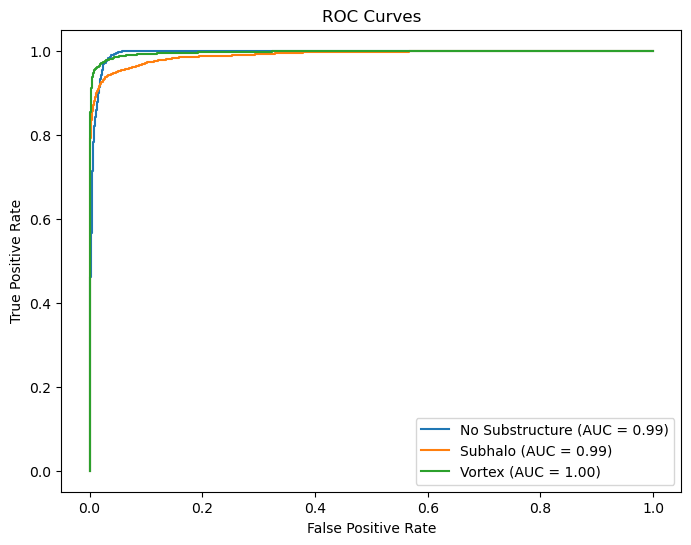

In [30]:
from sklearn.preprocessing import label_binarize

def evaluate(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Convert outputs to probabilities (Softmax)
            probs = torch.softmax(outputs, dim=1)  # Ensure predictions sum to 1

            all_preds.append(probs.cpu().numpy())  # Store probabilities
            all_labels.append(labels.cpu().numpy())  # Store true labels

    all_preds = np.concatenate(all_preds)  # Shape: (N, num_classes)
    all_labels = np.concatenate(all_labels)  # Shape: (N,)

    # One-hot encode labels for ROC curve
    all_labels = label_binarize(all_labels, classes=[0, 1, 2])

    plot_roc_curve(all_labels, all_preds, class_names=["No Substructure", "Subhalo", "Vortex"])

evaluate(model, val_loader)